In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# 1. Read each file, making sure the “date” column is parsed as datetime:
df_train   = pd.read_csv('/content/drive/MyDrive/occupancy_dataset/datatraining.txt',   parse_dates=['date'])
df_test1   = pd.read_csv('/content/drive/MyDrive/occupancy_dataset/datatest.txt',       parse_dates=['date'])
df_test2   = pd.read_csv('/content/drive/MyDrive/occupancy_dataset/datatest2.txt',      parse_dates=['date'])

# 2. Concatenate into one:
df_occ = pd.concat([df_train, df_test1, df_test2], ignore_index=True)

In [3]:
# Drop the first unnamed column (pandas will usually call it something like 'Unnamed: 0')
df_occ = df_occ.drop(columns=[col for col in df_occ.columns if 'Unnamed' in col])

# Double-check columns
print(df_occ.columns)
# ['date','Temperature','Humidity','Light','CO2','HumidityRatio','Occupancy']

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')


In [4]:
df_occ = df_occ.sort_values('date').drop_duplicates(subset='date')
df_occ = df_occ.set_index('date')

In [5]:
df_occ_hourly = df_occ.resample('1H').mean().interpolate()

/tmp/ipython-input-5-626486412.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_occ_hourly = df_occ.resample('1H').mean().interpolate()


In [6]:
df_occ_hourly.isna().sum()

,0
Temperature,0
Humidity,0
Light,0
CO2,0
HumidityRatio,0
Occupancy,0


In [8]:
import pandas as pd

# 1. Core time‐series
df_train = pd.read_csv(
    '/content/drive/MyDrive/dataset/power-laws-forecasting-energy-consumption-training-data.csv',
    sep=';', parse_dates=['Timestamp']
)

# 2. Metadata
df_meta = pd.read_csv(
    '/content/drive/MyDrive/dataset/power-laws-forecasting-energy-consumption-metadata.csv',
    sep=';'
)

# 3. Weather
df_weather = pd.read_csv(
    '/content/drive/MyDrive/dataset/power-laws-forecasting-energy-consumption-weather.csv',
    sep=';', parse_dates=['Timestamp']
)

# 4. Holidays
df_holidays = pd.read_csv(
    '/content/drive/MyDrive/dataset/power-laws-forecasting-energy-consumption-holidays.csv',
    sep=';', parse_dates=['Date']
)

In [9]:
SITE = 42
energy = df_train[df_train.SiteId == SITE].copy()
weather = df_weather[df_weather.SiteId == SITE].copy()
holidays = df_holidays[df_holidays.SiteId == SITE].copy()
meta = df_meta[df_meta.SiteId == SITE].copy()

In [10]:
energy = (
    energy
    .set_index('Timestamp')
    .Value
    .resample('1H')
    .mean()
    .interpolate()
    .to_frame(name='Power')
)

/tmp/ipython-input-10-3095420162.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


In [11]:
weather = (
    weather
    .set_index('Timestamp')
    .Temperature
    .resample('1H')
    .mean()
    .interpolate()
    .to_frame()
)

/tmp/ipython-input-11-3490264609.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


In [15]:
holidays['Date'] = holidays['Date'].dt.date
energy['IsHoliday'] = pd.Series(energy.index.date, index=energy.index).isin(holidays['Date'])

In [16]:
energy['SurfaceArea']     = meta.Surface.values[0]
energy['BaseTemperature'] = meta.BaseTemperature.values[0]

In [32]:
# energy = energy.tz_convert(None)
df_occ_hourly = df_occ_hourly.tz_convert('UTC')

In [50]:
# --- DEBUGGING: CHECK DATE RANGES ---
print("--- Date Range Inspection ---")
print(f"Energy Data Range:    {energy.index.min()} to {energy.index.max()}")
print(f"Weather Data Range:   {weather.index.min()} to {weather.index.max()}")
print(f"Occupancy Data Range: {df_occ_hourly.index.min()} to {df_occ_hourly.index.max()}")
print("-----------------------------")

--- Date Range Inspection ---
Energy Data Range:    2015-11-02 11:00:00+00:00 to 2017-12-04 02:00:00+00:00
Weather Data Range:   2015-01-01 01:00:00+00:00 to 2017-12-30 22:00:00+00:00
Occupancy Data Range: 2015-02-02 14:00:00+00:00 to 2015-02-18 09:00:00+00:00
-----------------------------


In [53]:
# 1. Create time-based features on the energy index
df = energy.copy()
df['Hour']      = df.index.hour
df['DayOfWeek'] = df.index.dayofweek  # Monday=0 … Sunday=6
df['IsWeekend'] = df['DayOfWeek'].isin([5,6])

# 2. Define a function to simulate occupancy
def simulate_occupancy(hour, is_weekend, is_holiday):
    if is_weekend or is_holiday:
        return 0.1   # almost empty
    if  8 <= hour < 11:
        return 0.6   # arrival/shake-out
    if 11 <= hour < 18:
        return 1.0   # full load
    if 18 <= hour < 21:
        return 0.5   # wrap-up
    return 0.2       # after hours

# 3. Apply it
df['SimOccupancy'] = df.apply(
    lambda row: simulate_occupancy(
        row['Hour'],
        row['IsWeekend'],
        row['IsHoliday']
    ), axis=1
)

In [54]:
# Join the weather temperature
df = df.join(weather.rename(columns={'Temperature':'OutdoorTemp'}), how='left')

# Bring in static metadata (SurfaceArea, BaseTemperature already in `df`)
# If you like, add temp difference:
df['TempDiff'] = abs(df['OutdoorTemp'] - df['BaseTemperature'])

In [55]:
# 1. Peek at the first few rows
print(df.head())

# 2. Check data types and non-null counts
print(df.info())

# 3. Summary statistics
print(df.describe())

# 4. Confirm no NaNs slipped in
print(df.isna().sum())

                                  Power  IsHoliday  SurfaceArea  \
Timestamp                                                         
2015-11-02 11:00:00+00:00  55627.804770      False  1032.735063   
2015-11-02 12:00:00+00:00  57657.393755      False  1032.735063   
2015-11-02 13:00:00+00:00  57499.701085      False  1032.735063   
2015-11-02 14:00:00+00:00  53682.063630      False  1032.735063   
2015-11-02 15:00:00+00:00  52798.366746      False  1032.735063   

                           BaseTemperature  Hour  DayOfWeek  IsWeekend  \
Timestamp                                                                
2015-11-02 11:00:00+00:00             18.0    11          0      False   
2015-11-02 12:00:00+00:00             18.0    12          0      False   
2015-11-02 13:00:00+00:00             18.0    13          0      False   
2015-11-02 14:00:00+00:00             18.0    14          0      False   
2015-11-02 15:00:00+00:00             18.0    15          0      False   

           

In [57]:
print(df.index.min(), df.index.max())

2015-11-02 11:00:00+00:00 2017-12-04 02:00:00+00:00


In [58]:
sampling_diffs = df.index.to_series().diff().value_counts()
print(sampling_diffs.head())

Timestamp
0 days 01:00:00    18303
Name: count, dtype: int64


In [59]:
print(df.head(3))

                                  Power  IsHoliday  SurfaceArea  \
Timestamp                                                         
2015-11-02 11:00:00+00:00  55627.804770      False  1032.735063   
2015-11-02 12:00:00+00:00  57657.393755      False  1032.735063   
2015-11-02 13:00:00+00:00  57499.701085      False  1032.735063   

                           BaseTemperature  Hour  DayOfWeek  IsWeekend  \
Timestamp                                                                
2015-11-02 11:00:00+00:00             18.0    11          0      False   
2015-11-02 12:00:00+00:00             18.0    12          0      False   
2015-11-02 13:00:00+00:00             18.0    13          0      False   

                           SimOccupancy  OutdoorTemp  TempDiff  
Timestamp                                                       
2015-11-02 11:00:00+00:00           1.0         21.0       3.0  
2015-11-02 12:00:00+00:00           1.0         21.0       3.0  
2015-11-02 13:00:00+00:00        

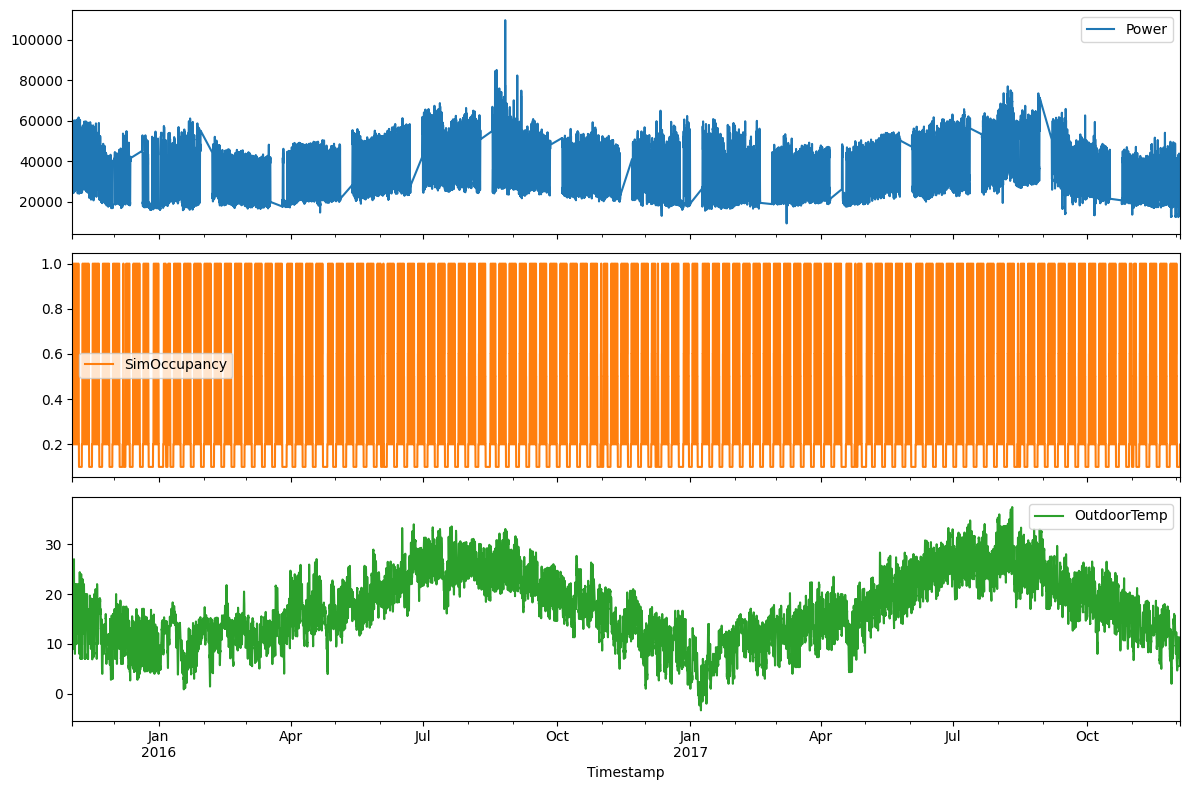

In [60]:
import matplotlib.pyplot as plt

df[['Power', 'SimOccupancy', 'OutdoorTemp']].plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()


In [63]:
# 1) Train split:
train = df.loc[:'2017-10-31']                # all data up to Oct-31
val   = df.loc['2017-11-01':'2017-12-01']    # reserve Nov for validation

In [64]:
# 2) Save train.csv (with target)
train.to_csv('train.csv', index_label='timestamp',
             columns=['Power',
                      'IsHoliday','Hour','DayOfWeek',
                      'SimOccupancy','OutdoorTemp','TempDiff'],
             header=['target:Power',
                     'exog:IsHoliday','exog:Hour','exog:DayOfWeek',
                     'exog:SimOccupancy','exog:OutdoorTemp','exog:TempDiff'])

In [66]:
# 3) Build forecast.csv (no target)
horizon = 24  # next 24 hours
last_ts = df.index.max()
future_idx = pd.date_range(
    start=last_ts + pd.Timedelta(hours=1),
    periods=horizon, freq='1H'
)

/tmp/ipython-input-66-434749183.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(


In [68]:
import pandas as pd

# … after you’ve built future_idx and forecast_df …

# Instead of future_idx.date.astype(...).isin(...), do:
forecast_df['exog:IsHoliday'] = pd.Series(
    forecast_df.index.date,           # array of python dates
    index=forecast_df.index
).isin(holidays['Date'])

# And the rest stays the same:
forecast_df['exog:Hour'] = forecast_df.index.hour
forecast_df['exog:DayOfWeek'] = forecast_df.index.dayofweek
forecast_df['exog:SimOccupancy'] = forecast_df.index.to_series().apply(
    lambda ts: simulate_occupancy(
        ts.hour, ts.dayofweek >= 5, ts.date() in holidays['Date']
    )
)
# Carry-forward weather and temp diff
last_temp = df['OutdoorTemp'].iloc[-1]
base_temp = df['BaseTemperature'].iloc[-1]

forecast_df['exog:OutdoorTemp'] = last_temp
forecast_df['exog:TempDiff'] = abs(last_temp - base_temp)